# (MBTI) Myers-Briggs Personality Type Prediction

* Extroversion vs. Introversion
    * I - 0
    * E - 1 
    
* Sensing vs. Intuition 
    * N - 0 
    * S - 1
    
* Thinking vs. Feeling
    * F - 0
    * T - 1
    
* Judging vs. Perceiving
    * P - 0
    * J - 1 
    
## MACHINE LEARNING - IMPLEMENTING & COMPARING DIFFERENT CLASSIFIERS  

In [21]:
# importing dependencies here
import numpy as np
import pandas as pd
import os

# visualizations
import matplotlib.pyplot as plt

# data stratifying and splitting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer

# class imbalance
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler

# algorithms/models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

# performance check
import time
import warnings

warnings.filterwarnings("ignore")

# sparse to dense
from sklearn.base import TransformerMixin


class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


# saving the model
from joblib import dump

# code formatter
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [22]:
# reading the final dataset
path_to_csv = os.path.join("..", "data", "clean_data_3.csv")
personality_data = pd.read_csv(path_to_csv)

<IPython.core.display.Javascript object>

In [23]:
# checking top records
personality_data.head(2)

,type,is_Extrovert,is_Sensing,is_Thinking,is_Judging,posts,clean_posts,compound_sentiment,pos_sentiment,neg_sentiment,...,em,colons,emojis,word_count,unique_words,post_length_var,upper,link_count,ellipses,img_count
0,INFJ,0,0,0,1,'When asked of the things you wish you did ear...,asked thing wish earlier find answering...,0.99980,0.409639,0.131455,...,0.22,0.32,0.08,30.98,14.92,78.414931,1.46,0.04,0.62,0.0
1,INFJ,0,0,0,1,'I love both and they are equally important to...,love equally important music window soul in...,0.99995,0.605087,0.131455,...,0.36,0.14,0.00,28.58,12.72,160.744400,1.62,0.02,0.04,0.0


<IPython.core.display.Javascript object>

### Setting predictors and target variable


In [24]:
# setting X to clean_posts, compound sentiment score, pos tags and various other counts
X = personality_data[
    [
        "clean_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "qm",
        "em",
        "colons",
        "emojis",
        "word_count",
        "unique_words",
        "upper",
        "link_count",
        "ellipses",
        "img_count",
    ]
]

# setting y to four target classes -> is_Extrovert, is_Sensing, is_Thinking, is_Judging
y = personality_data.iloc[:, 1:5]

# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(8588, 22)
(8588, 4)


<IPython.core.display.Javascript object>

### Creating a list of words (other than the stop words) to be dropped to improve model performanace

In [25]:
additional_stopwords = [
    "hey",
    "hello",
    "briggs",
    "cat",
    "car",
    "mbti",
    "soup",
    "tea",
    "sport",
    "snow",
    "christmas",
]

<IPython.core.display.Javascript object>

### Setting up preprocessor for vectorization and selecting best counts and scores

In [26]:
# preprocessing steps for selecting best k columns/features from counts & scores and for vectorizing words

counts_n_scores = [
    "compound_sentiment",
    "ADJ_avg",
    "ADP_avg",
    "ADV_avg",
    "CONJ_avg",
    "DET_avg",
    "NOUN_avg",
    "NUM_avg",
    "PRT_avg",
    "PRON_avg",
    "VERB_avg",
    "qm",
    "em",
    "colons",
    "emojis",
    "word_count",
    "unique_words",
    "upper",
    "link_count",
    "ellipses",
    "img_count",
]

# for selecting k best features from features other than words
best_k_features = make_pipeline(MinMaxScaler(), SelectKBest(f_classif, k=10))

# setting up preprocessing for TF-IDF vectorizer
preprocesser_tf = ColumnTransformer(
    transformers=[
        (
            "tfidf",
            TfidfVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

# setting up preprocessing for COUNT vectorizer
preprocesser_ct = ColumnTransformer(
    transformers=[
        (
            "ct_vect",
            CountVectorizer(min_df=25, max_df=0.85, stop_words=additional_stopwords),
            "clean_posts",
        ),
        ("selectbest", best_k_features, counts_n_scores),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

### Modelling

In [36]:
# setting up the personality dictionary for printing scores for each class
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Sensing": "Sensing vs Intuition",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}

# function to build the model for predicting each of the 4 target classes
def build_model(model, X, target, vectorizer_name):

    for col in target.columns:

        print(f"\n{mbti_type[col]}")
        target = y[col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, target, test_size=0.2, random_state=42, stratify=target
        )

        # model training
        model.fit(X_train, y_train)

        # y_hat
        y_pred = model.predict(X_test)

        # y_probability
        y_proba = model.predict_proba(X_test)[:, 1]

        # precision recall score
        average_precision = average_precision_score(y_test, y_proba)

        # model evaluation
        print(
            f"Geometric Mean Score: {geometric_mean_score(y_test, y_pred, average='weighted'):.2f}"
        )
        print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.2f}")
        print(f"Average Precision-Recall Score: {average_precision:.2f}")
        print(classification_report_imbalanced(y_test, y_pred))


<IPython.core.display.Javascript object>

In [37]:
# save the model to disk
filename = "finalized_model.sav"
pickle.dump(model, open(filename, "wb"))

<IPython.core.display.Javascript object>

In [39]:
loaded_model = pickle.load(open(filename, "rb"))


<IPython.core.display.Javascript object>

### TF-IDF Logistic Regression

In [28]:
%%time

tfidf_logistic_regression = imb_make_pipeline(
    preprocesser_tf, RandomUnderSampler(), LogisticRegressionCV()
)
build_model(tfidf_logistic_regression, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.69
ROC-AUC Score: 0.76
Average Precision-Recall Score: 0.49
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.69      0.69      0.78      0.69      0.48      1322
          1       0.40      0.69      0.69      0.51      0.69      0.48       396

avg / total       0.77      0.69      0.69      0.71      0.69      0.48      1718


Sensing vs Intuition
Geometric Mean Score: 0.73
ROC-AUC Score: 0.80
Average Precision-Recall Score: 0.40
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.69      0.77      0.80      0.73      0.53      1481
          1       0.28      0.77      0.69      0.41      0.73      0.53       237

avg / total       0.86      0.70      0.76      0.75      0.73      0.53      1718


Thinking vs Feeling
Geometric Mean Score: 0.79
ROC-AUC Score: 0.87
Average Precision-Recall Score: 0.84
           

<IPython.core.display.Javascript object>

### TF-IDF Naive Bayes

In [13]:
%%time
tfidf_nb = imb_make_pipeline(
    preprocesser_tf, DenseTransformer(), RandomUnderSampler(), MultinomialNB(),
)
build_model(tfidf_nb, X, y, "tfidf")


Extrovert vs Introvert
Geometric Mean Score: 0.69
ROC-AUC Score: 0.77
Average Precision-Recall Score: 0.47
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.63      0.75      0.74      0.69      0.46      1322
          1       0.38      0.75      0.63      0.50      0.69      0.47       396

avg / total       0.77      0.66      0.72      0.68      0.69      0.47      1718


Sensing vs Intuition
Geometric Mean Score: 0.70
ROC-AUC Score: 0.78
Average Precision-Recall Score: 0.37
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.65      0.75      0.77      0.70      0.48      1481
          1       0.26      0.75      0.65      0.38      0.70      0.49       237

avg / total       0.85      0.67      0.73      0.72      0.70      0.48      1718


Thinking vs Feeling
Geometric Mean Score: 0.76
ROC-AUC Score: 0.85
Average Precision-Recall Score: 0.80
           

<IPython.core.display.Javascript object>

### Final Model - Logistic Regression with TF-IDF Vectorization

Selecting TF-IDF Logistic Regression as our final model as it returned the highest scores for all metrics - accuracy, precision, recall, roc-auc, avg_precision_recall as compared to other models.


Extrovert vs Introvert
               coef
word               
ne         5.370225
ni        -4.468107
fun        3.902735
guy        2.854980
bored      2.786018
feel      -2.721921
fuck       2.636568
friend     2.623920
nt         2.564286
super      2.539891
ego        2.485359
world     -2.484792
dream     -2.477711
game      -2.470215
let        2.462790
shit       2.459799
small     -2.456899
love       2.361739
listening -2.333086
business   2.310090
afraid    -2.248685

Sensing vs Intuition
                  coef
word                  
se            3.333746
si            3.034500
nt           -2.818668
world        -2.727494
rant          2.650269
type          2.563802
super         2.266320
practical     2.201185
fun           2.192759
human        -2.122548
feel         -2.119473
idea         -2.112315
husband       2.029692
book         -2.000659
ne           -1.951471
seem         -1.920700
stereotype    1.887638
hope         -1.880331
intelligence -1.797779
concept    

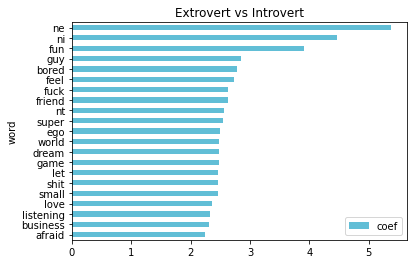

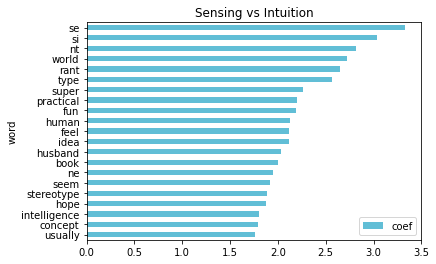

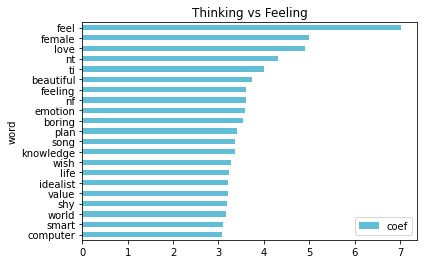

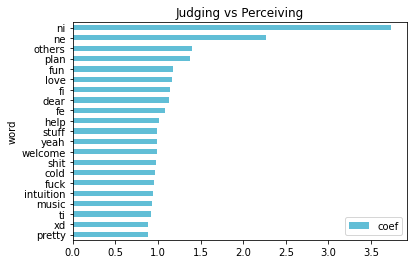

<IPython.core.display.Javascript object>

In [29]:
%%time

for col in y.columns:
    
    print(f"\n{mbti_type[col]}")

    target = y[col]

    tfidf_logistic_regression = imb_make_pipeline(
        preprocesser_tf,
        RandomUnderSampler(),
        LogisticRegressionCV()
    )
    
    # training the data on entire dataset
    tfidf_logistic_regression.fit(X, target)
    
    # feature importance   
    coef = tfidf_logistic_regression[-1].coef_[0]  
    word = tfidf_logistic_regression[0].named_transformers_["tfidf"].get_feature_names()
    word_list = list(zip(word, coef))         
    result = pd.DataFrame(word_list, columns=["word", "coef"]).set_index("word")    
    result = result.reindex(result.coef.abs().sort_values(ascending=False).index)[0:21]
    print(result)
    
    # plotting feature importance
    result["coef"] = result["coef"].apply(lambda x: abs(x))
    result.sort_values("coef", inplace=True)
    result.plot(kind="barh", color="#61BED6", title=mbti_type[col])
  
    # saving the model
    dump(tfidf_logistic_regression, f"clf_{col}.joblib")

In [31]:
import pickle


<IPython.core.display.Javascript object>

In [32]:
pickle.dump(tfidf_logistic_regression, open('model.pkl', 'wb'))


<IPython.core.display.Javascript object>

In [33]:
model = pickle.load(open("model.pkl", "rb"))
print(model)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(max_df=0.85,
                                                                  min_df=25,
                                                                  stop_words=['hey',
                                                                              'hello',
                                                                              'briggs',
                                                                              'cat',
                                                                              'car',
                                                                              'mbti',
                                                                              'soup',
                                                                              'tea',


<IPython.core.display.Javascript object>

In [16]:
!pip install Flask

<IPython.core.display.Javascript object>

In [17]:
import numpy as np
from flask import Flask, request, jsonify, render_template
import pickle
from sklearn.preprocessing import StandardScaler

<IPython.core.display.Javascript object>

In [18]:
app = Flask(__name__)

<IPython.core.display.Javascript object>

In [19]:
import pickle

pickle.dump(model, open("model.pkl", "wb"))
model1 = pickle.load(open("model.pkl", "rb"))
print(model1)

NameError: name 'model' is not defined

<IPython.core.display.Javascript object>

In [15]:
model1 = pickle.load(open("model.pkl", "rb"))

NameError: name 'pickle' is not defined

<IPython.core.display.Javascript object>